## Load Libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
import pathlib

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

## Load Dataset

In [2]:
data_dir = './VPN_Traffic/'

batch_size = 32
img_height = 32
img_width = 32
epochs = 15

#### Split Training and Validation Sets

In [3]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    labels="inferred",
    validation_split=0.2,
    subset="training",
    seed=69,
    color_mode="grayscale",
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 68338 files belonging to 5 classes.
Using 54671 files for training.


In [4]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    labels="inferred",
    validation_split=0.2,
    subset="validation",
    seed=69,
    color_mode="grayscale",
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 68338 files belonging to 5 classes.
Using 13667 files for validation.


In [5]:
class_names = train_ds.class_names
print(class_names)

['audio', 'chat', 'email', 'files', 'video']


#### Batch Shapes

In [6]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 32, 32, 1)
(32,)


#### Dataset Performance Optimization

In [7]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Create The Model

In [8]:
num_classes = 5

model = Sequential([
    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 1)),
    
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    
    layers.Dropout(0.5),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes)
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 32, 32, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 16)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 64)          18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 64)          0

## Training

In [9]:
import shutil
logdir='./callbacks_cnn'

if os.path.exists(logdir):
    shutil.rmtree(logdir) 
os.mkdir(logdir)

output_model_file=os.path.join(logdir,"model.h5")

callbacks = [
    keras.callbacks.TensorBoard(logdir),
    keras.callbacks.ModelCheckpoint(output_model_file,save_best_only=True),
    keras.callbacks.EarlyStopping(patience=5,min_delta=1e-3)
]

In [10]:
history = model.fit(train_ds, epochs=epochs, validation_data=(val_ds), callbacks=callbacks)

Epoch 1/15
1709/1709 [==============================] - 24s 7ms/step - loss: 0.6724 - accuracy: 0.7740 - val_loss: 0.5163 - val_accuracy: 0.8367
Epoch 2/15
1709/1709 [==============================] - 4s 2ms/step - loss: 0.5327 - accuracy: 0.8339 - val_loss: 0.4628 - val_accuracy: 0.8556
Epoch 3/15
1709/1709 [==============================] - 4s 2ms/step - loss: 0.4863 - accuracy: 0.8502 - val_loss: 0.4303 - val_accuracy: 0.8676
Epoch 4/15
1709/1709 [==============================] - 4s 2ms/step - loss: 0.4560 - accuracy: 0.8600 - val_loss: 0.4140 - val_accuracy: 0.8728
Epoch 5/15
1709/1709 [==============================] - 4s 2ms/step - loss: 0.4387 - accuracy: 0.8666 - val_loss: 0.4057 - val_accuracy: 0.8760
Epoch 6/15
1709/1709 [==============================] - 4s 2ms/step - loss: 0.4266 - accuracy: 0.8705 - val_loss: 0.3960 - val_accuracy: 0.8778
Epoch 7/15
1709/1709 [==============================] - 4s 2ms/step - loss: 0.4154 - accuracy: 0.8755 - val_loss: 0.3876 - val_accuracy

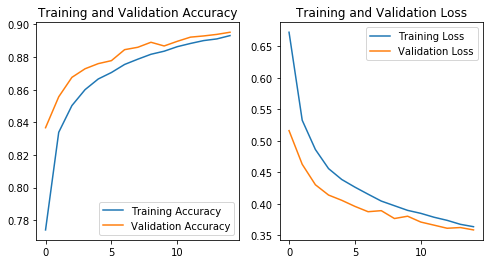

In [11]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Inference

In [12]:
img_path = './VPN_Traffic/chat/69.png'

img = keras.preprocessing.image.load_img(
    img_path, target_size=(img_height, img_width), color_mode="grayscale"
)

img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This packet most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This packet most likely belongs to chat with a 99.99 percent confidence.
